Ваша задача - создать модель машинного обучения для мониторинга безопасности одиноких пожилых людей на основе данных от датчиков газа, температуры и инфракрасных датчиков движения. Модель должна способна определять аномалии и необычное поведение, которые могут потребовать вмешательства или помощи.

- провести входной анализ данных (EDA)
- определить метрики для оценки эффективности модели
- сформировть baseline-модель
- предложить улучшенную модель и вывести ее в продакшн

Датасет содержит данные от датчиков газа и температуры, а также инфракрасных датчиков движения, установленных для мониторинга пожилого человека, проживающего один в собственном доме с 2019-11-06 по 2020-02-13. Измерения проводились с временным разрешением в 20 секунд. Датчики воздуха и газа измеряют температуру, влажность, уровень CO2, CO и MOX. Данные от датчиков позиции бинарны: для каждой комнаты 1 означает обнаружение движения в комнате, в то время как 0 означает возврат сенсора к базовому состоянию. Датасет также включает в себя 19 дней измерений (с 2020-01-25 по 2020-02-13), когда никто не находился в помещении (за исключением случайного посещения 2020-01-29 в 15:00) и используется в качестве эталонных данных. Разрешается использовать не весь набор признаков.

### EDA

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

In [ ]:
data = pd.read_csv('data\\database_gas.csv')
data.timestamp = data.timestamp.apply(lambda value: pd.to_datetime(value, utc=True)) 
data.head()

In [100]:
data.isna().sum()

timestamp        0
temperature      0
humidity         0
CO2CosIRValue    0
CO2MG811Value    0
MOX1             0
MOX2             0
MOX3             0
MOX4             0
COValue          0
dtype: int64

In [109]:
data.dtypes

timestamp        datetime64[ns, UTC]
temperature                  float64
humidity                     float64
CO2CosIRValue                float64
CO2MG811Value                float64
MOX1                         float64
MOX2                         float64
MOX3                         float64
MOX4                         float64
COValue                      float64
label                          int32
dtype: object

In [ ]:
features = ["temperature", "humidity", "CO2CosIRValue", "CO2MG811Value", "MOX1", "MOX2", "MOX3", "MOX4", "COValue"]

In [ ]:
dt = "2020-01-25"

Сгруппируем данные в бОльшие группы, например, в 30 минут

In [ ]:
data = data.groupby(pd.Grouper(key="timestamp", freq="30min")).agg("mean").reset_index()

Добавим метку того, что в квартире никто не находился

In [ ]:
data['label'] = np.where(data.timestamp>=dt, 1, 0)

In [104]:
sns.set(rc={'figure.figsize':(11, 5)})

Распределение признаков по времени

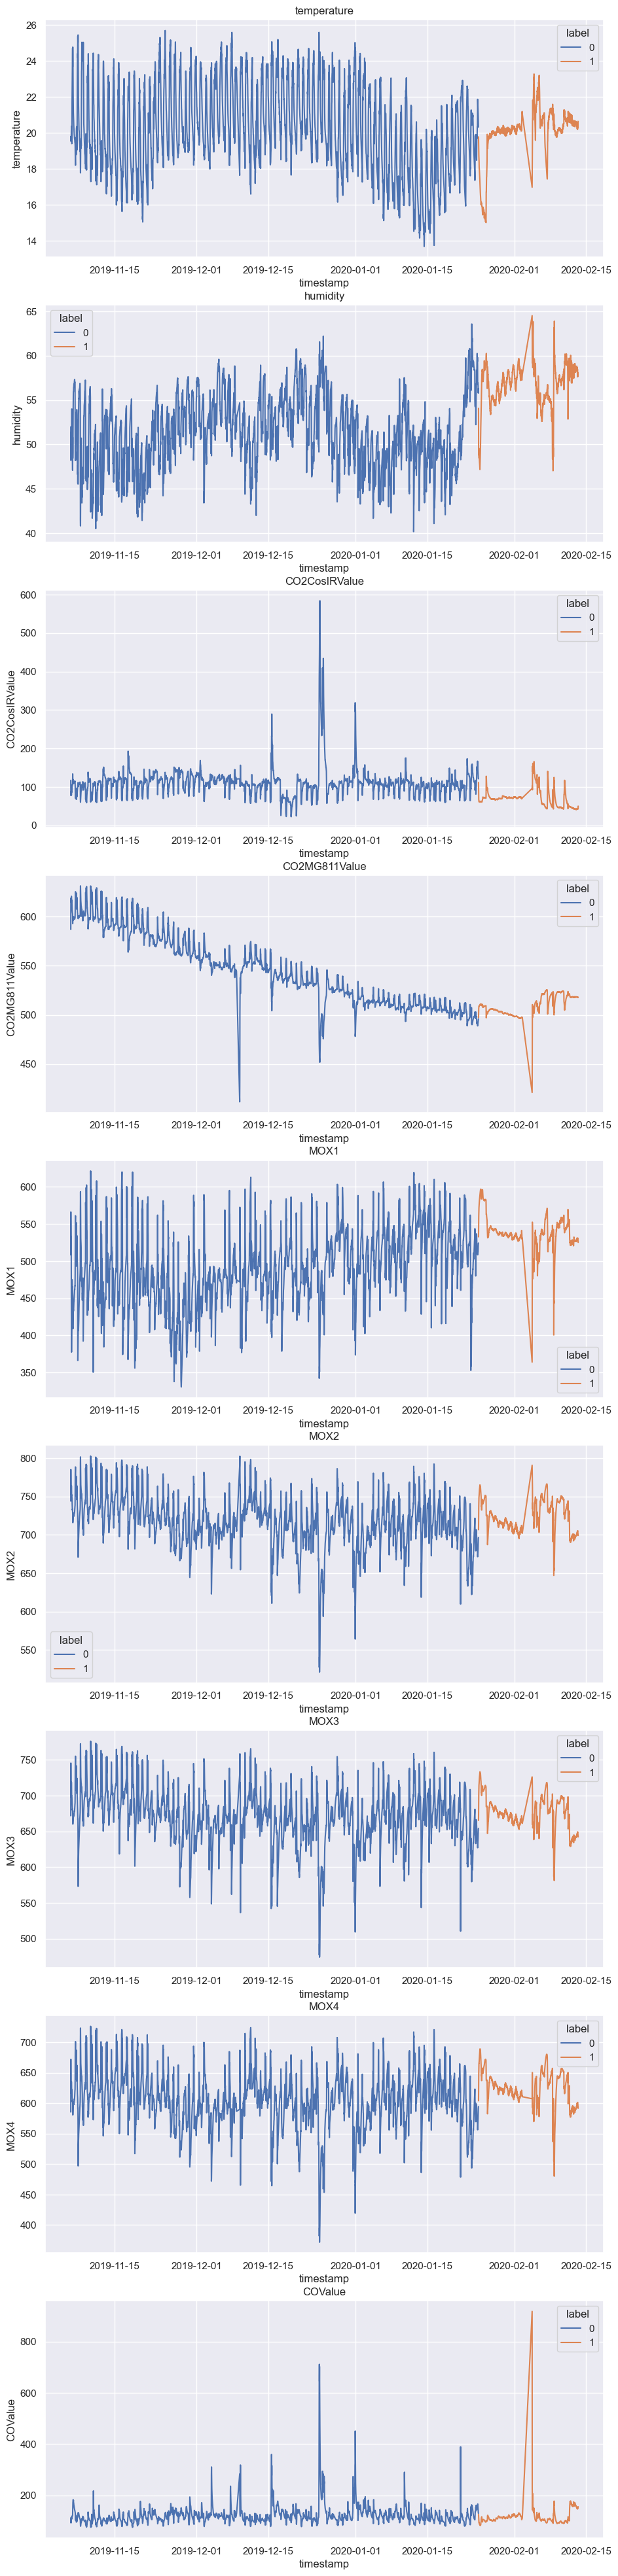

In [108]:
fig, ax = plt.subplots(len(features), 1, figsize=(11, 50))

for i, feature in enumerate(features):
    sns.lineplot(ax=ax[i], data=data, x='timestamp', y=feature, hue=data.label)
    ax[i].set_title(feature)

Видно, что распределения признаков после 2020-01-25 отличаются, однако притсутствуют выбросы в эталонных и не эталонных данных. При этом не до конца понятна природа этих выбросов. Но будем доверять описанию. <br />
Разметим данные после 2020-01-25 с меткой 1 - то есть как те, которые отличаются от нормальных, когда человек присутствует в квартире.

In [167]:
data[data.CO2CosIRValue==data.CO2CosIRValue.max()]

timestamp  temperature   humidity  CO2CosIRValue  \
2333 2019-12-25 01:00:00+00:00    24.507667  57.720667     583.888889   

      CO2MG811Value        MOX1        MOX2        MOX3   MOX4     COValue  \
2333     452.755556  385.633333  543.977778  491.133333  399.1  471.188889   

      label  hour  
2333    0.0   1.0

In [112]:
data[data.COValue==data.COValue.max()]

timestamp  temperature  humidity  CO2CosIRValue  \
4321 2020-02-04 11:00:00+00:00        16.97     64.51           96.0   

      CO2MG811Value   MOX1    MOX2   MOX3    MOX4  COValue  label  
4321          421.0  364.0  790.75  726.0  607.25    918.0      1

In [68]:
data[data.timestamp>dt].sort_values(by='CO2CosIRValue', ascending=False).head(5)

timestamp  temperature   humidity  CO2CosIRValue  \
4339 2020-02-04 20:00:00+00:00    23.271667  57.627333     165.755556   
4338 2020-02-04 19:30:00+00:00    22.936000  58.113444     161.744444   
4328 2020-02-04 14:30:00+00:00    20.900778  62.271222     161.177778   
4337 2020-02-04 19:00:00+00:00    23.093111  57.865000     160.900000   
4327 2020-02-04 14:00:00+00:00    21.820889  58.653444     153.988889   

      CO2MG811Value        MOX1        MOX2        MOX3        MOX4  \
4339     501.555556  498.622222  716.011111  649.188889  582.511111   
4338     501.922222  497.011111  716.377778  648.900000  581.822222   
4328     502.933333  478.922222  727.244444  656.955556  587.522222   
4337     502.366667  485.333333  708.466667  638.366667  569.811111   
4327     502.877778  476.200000  725.400000  654.722222  582.466667   

         COValue  label  hour  
4339  138.455556      1    20  
4338  144.422222      1    19  
4328  164.888889      1    14  
4337  150.877778      1    19  
4327  155.833333      1    14

Распределение признаков в зависимости от нахождения в доме человека

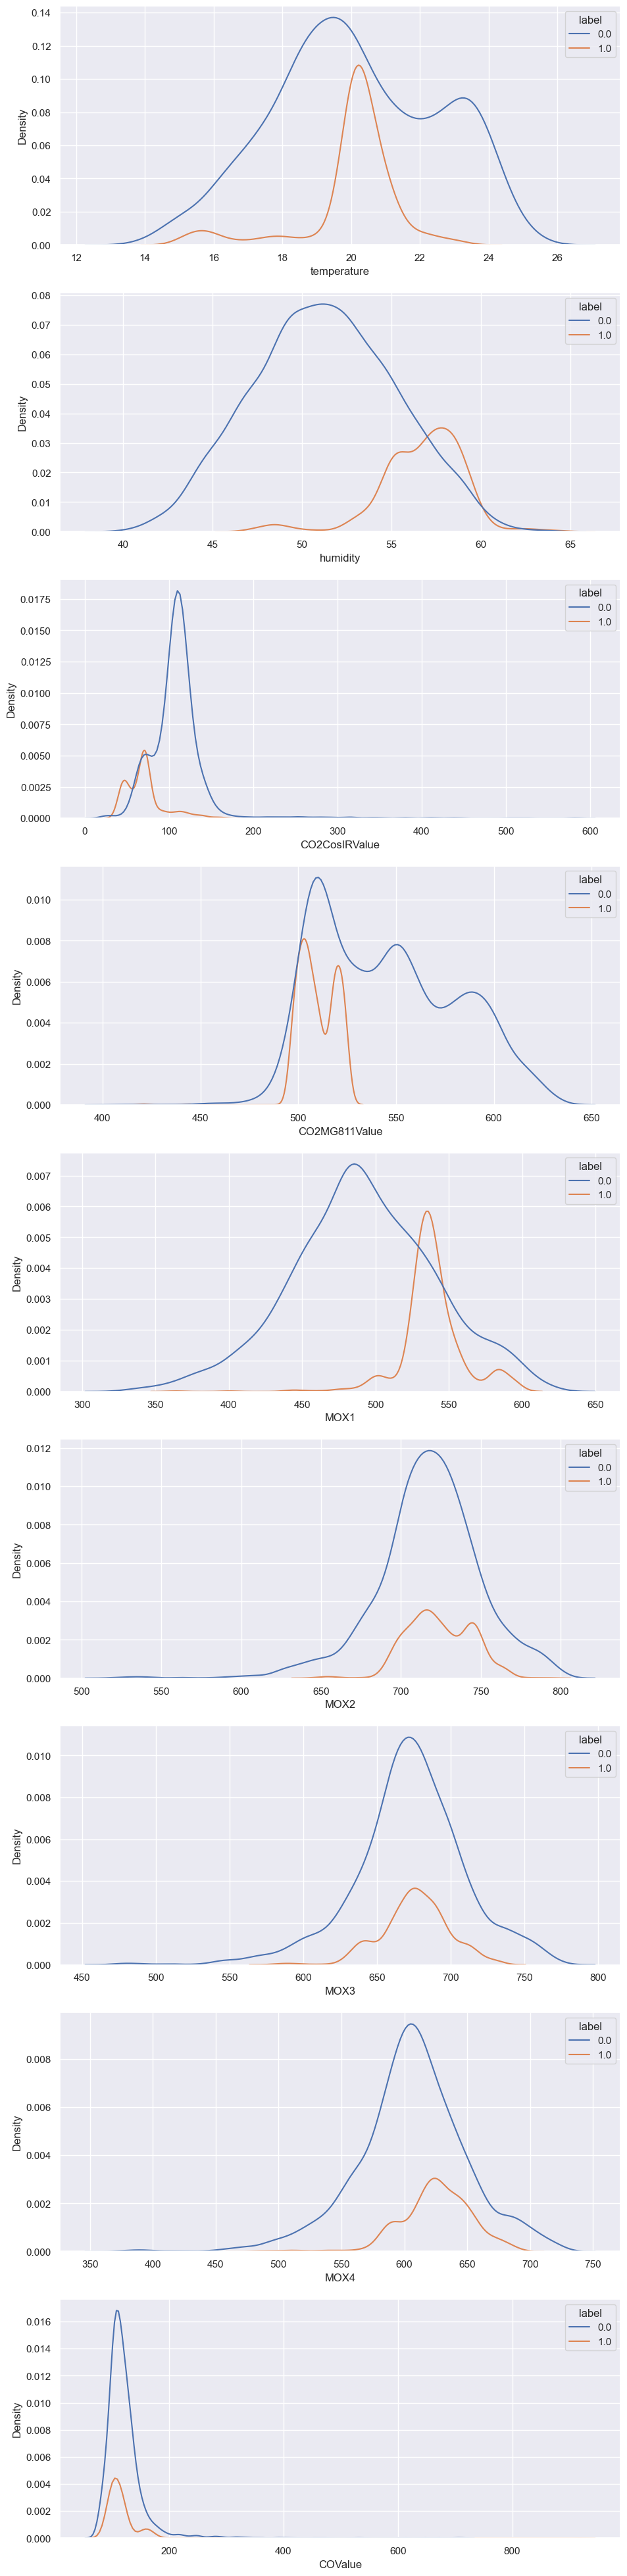

In [139]:
fig, ax = plt.subplots(len(features), 1, figsize=(11, 50))

for i, feature in enumerate(features):
    sns.kdeplot(ax=ax[i], data=data, x=feature, hue=data.label)
    #ax[i].set_title(feature)

In [ ]:
data['hour'] = data.timestamp.dt.hour

Распределение признаков по часам

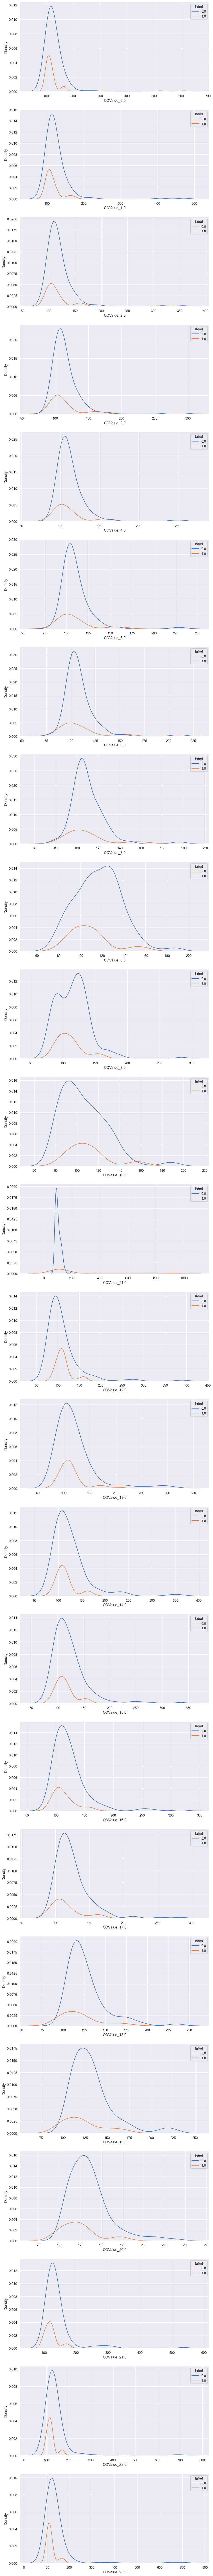

In [142]:
hours = data['hour'].unique()
hours.sort()
fig, ax = plt.subplots(len(hours), 1, figsize=(11, 150))

for i, hour in enumerate(hours):
    sns.kdeplot(ax=ax[i], data=data[data['hour']==hour], x=feature, hue=data.label)
    ax[i].set(xlabel=feature+'_'+str(hour))
    #ax[i].set_title('hour_'+str(hour))

Распределение признаков по часам, когда дома кто-то есть

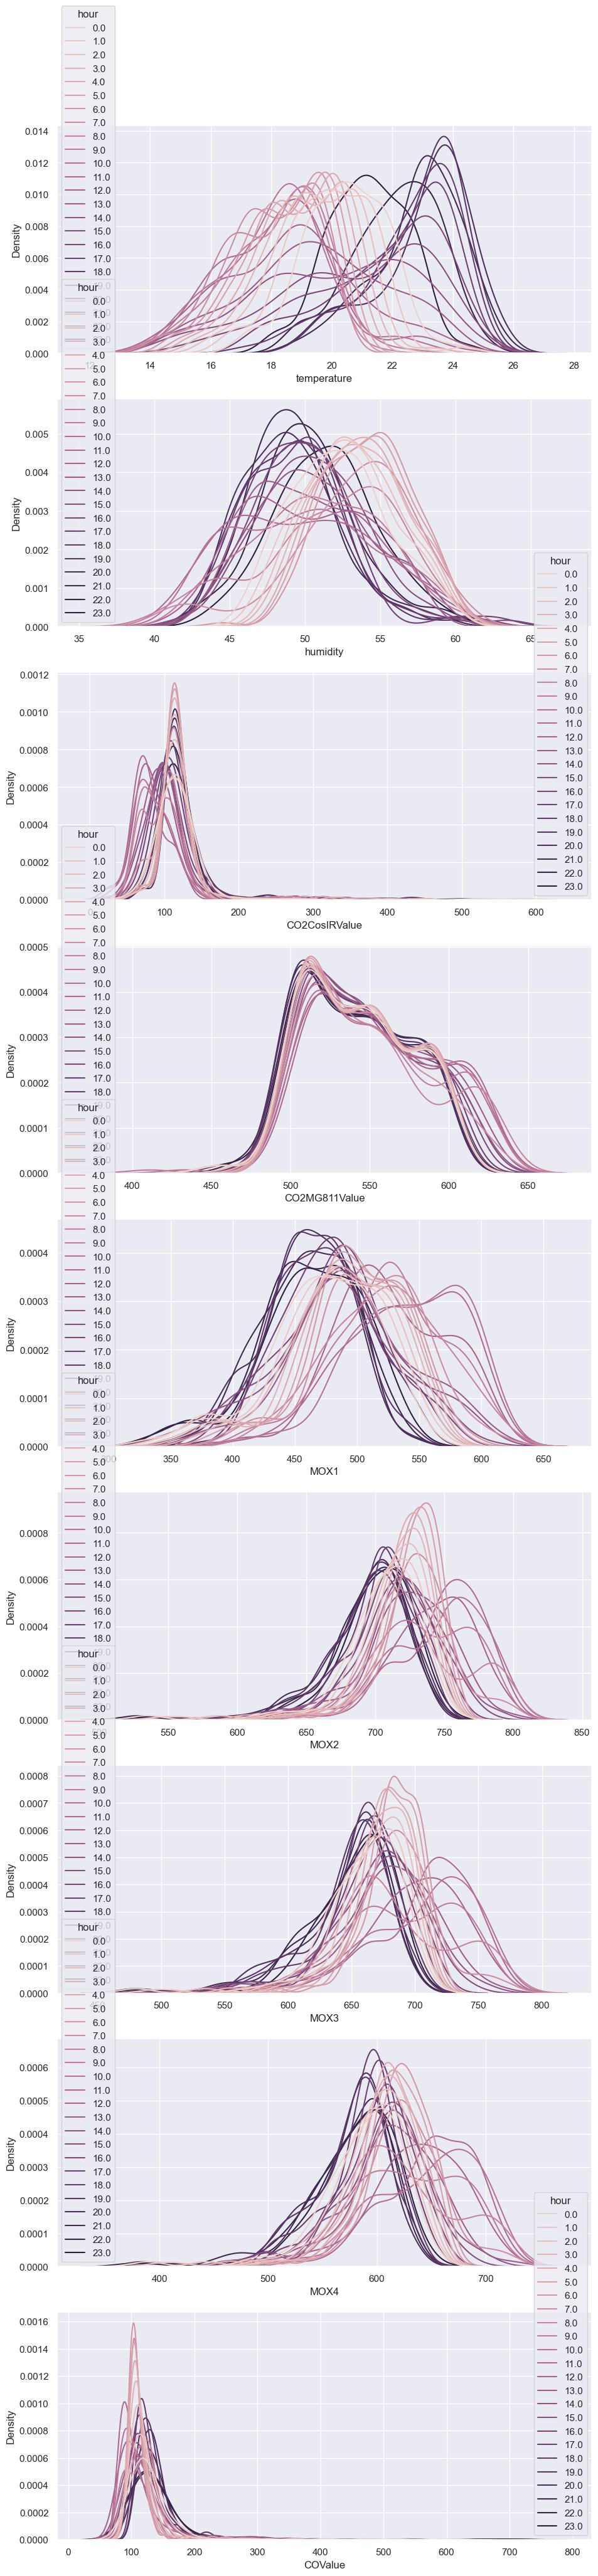

In [138]:
fig, ax = plt.subplots(len(features), 1, figsize=(11, 50))

for i, feature in enumerate(features):
    sns.kdeplot(ax=ax[i], data=data[data['label']==0], x=feature, hue=data['hour'])
    #ax[i].set_title(feature)

Распределение признаков по часам, когда дома никого нет

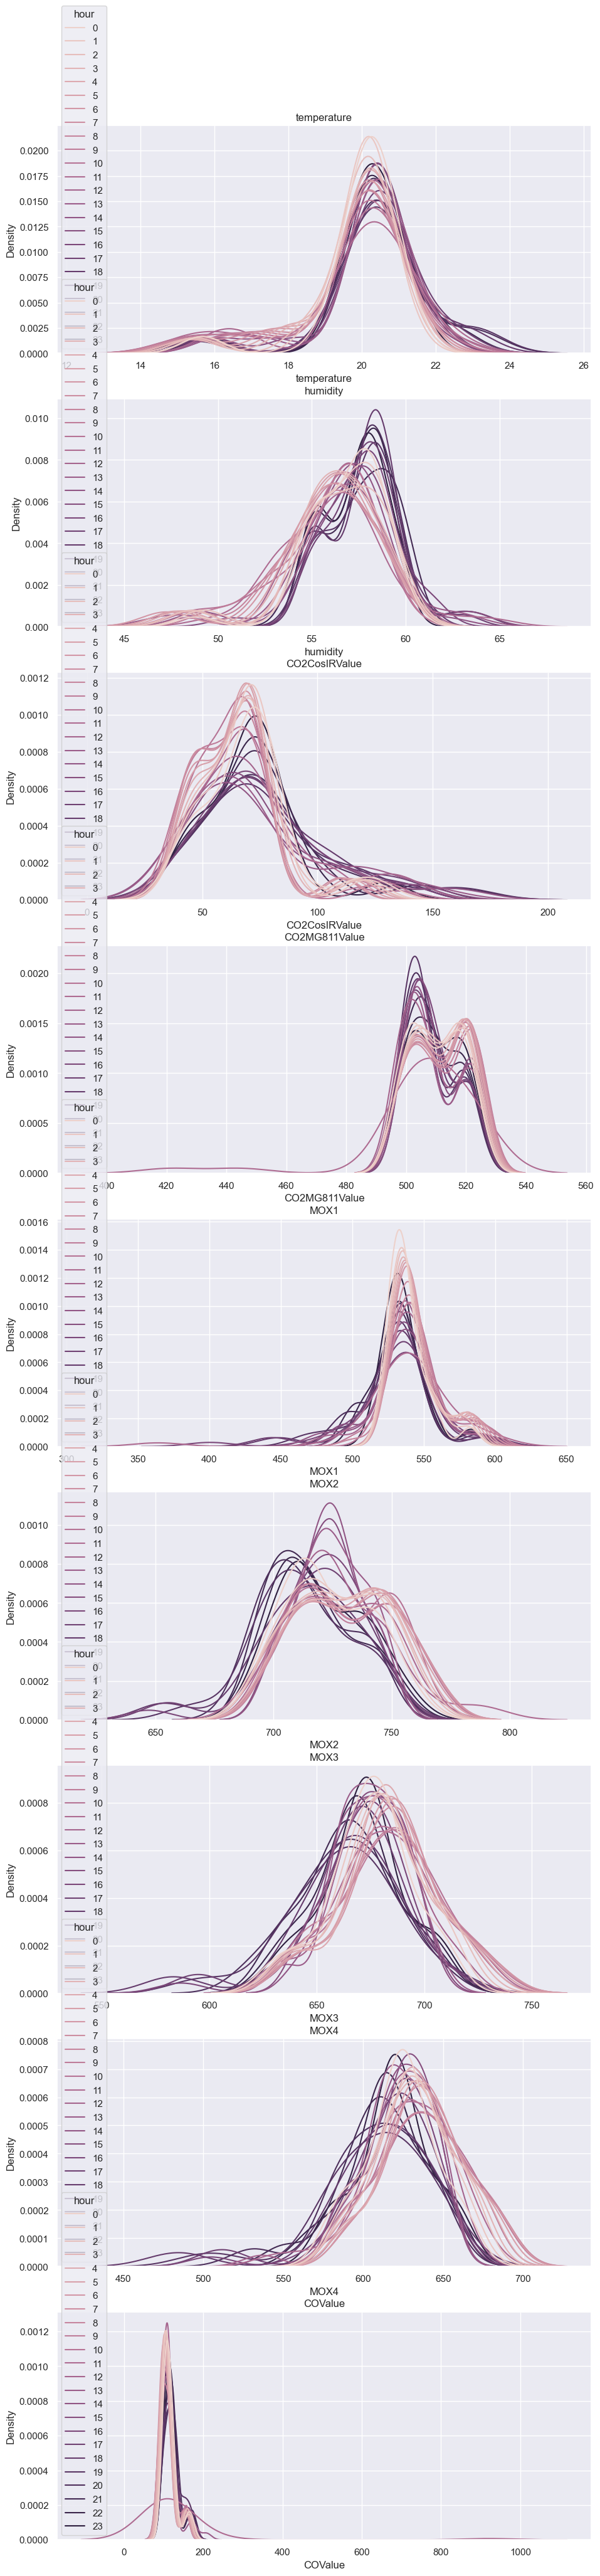

In [129]:
fig, ax = plt.subplots(len(features), 1, figsize=(11, 50))

for i, feature in enumerate(features):
    sns.kdeplot(ax=ax[i], data=data[data['label']==1], x=feature, hue=data['hour'])
    ax[i].set_title(feature)

Посмотрим на датчики движения

In [ ]:
pos = pd.read_csv('data/database_pos.csv')
pos.datetime = pos.datetime.apply(lambda value: pd.to_datetime(value, utc=True)) 
pos['label'] = np.where(pos.datetime>=dt, 1, 0)

Построим графики нахождения в компанатах в зависимости от даты

In [ ]:
rooms = ['Living room','Bedroom','Bathroom','Kitchen','Hallway']

pos['dt'] = pos.datetime.dt.strftime('%Y-%m-%d')

In [ ]:
subdata = pos.groupby('dt', as_index=False).max().drop('datetime', axis=1)
subdata['dt'] = subdata['dt'].astype('datetime64')

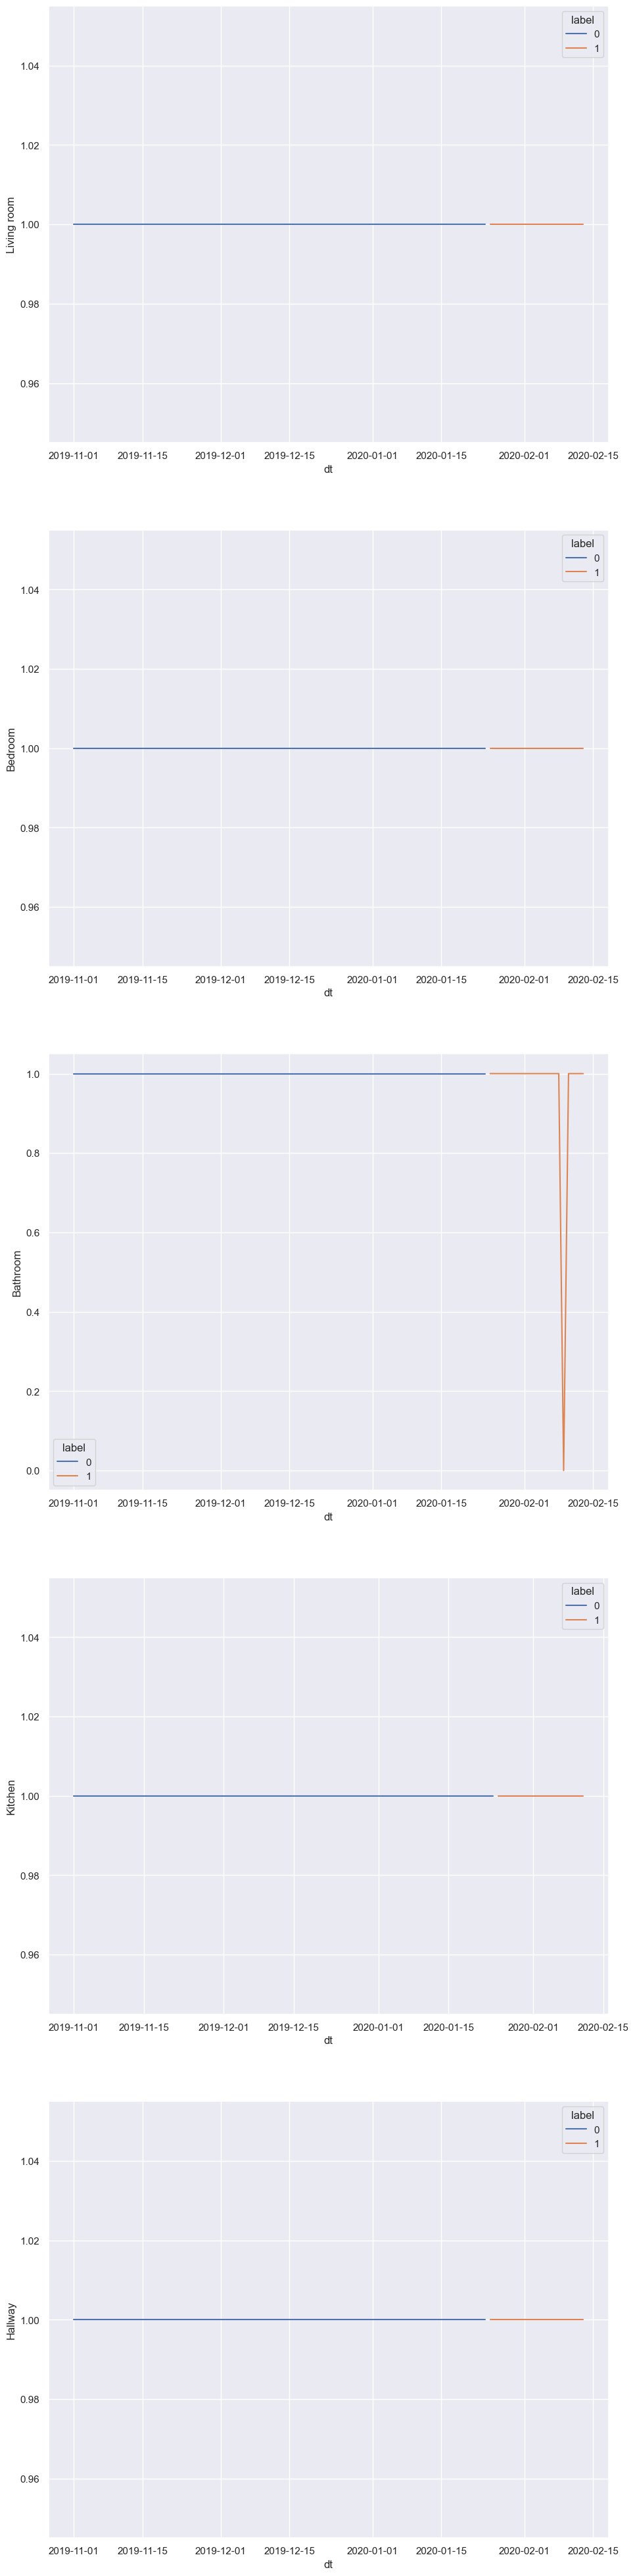

In [166]:
fig, ax = plt.subplots(len(rooms), 1, figsize=(11, 50))

for i, room in enumerate(rooms):
    sns.lineplot(ax=ax[i], data=subdata[['dt', room]], x='dt', y=room, hue=subdata['label'])

Почти во все дни все датчики (кроме одного) срабатывали. Это странно.

In [ ]:
data = data.dropna(axis=0)

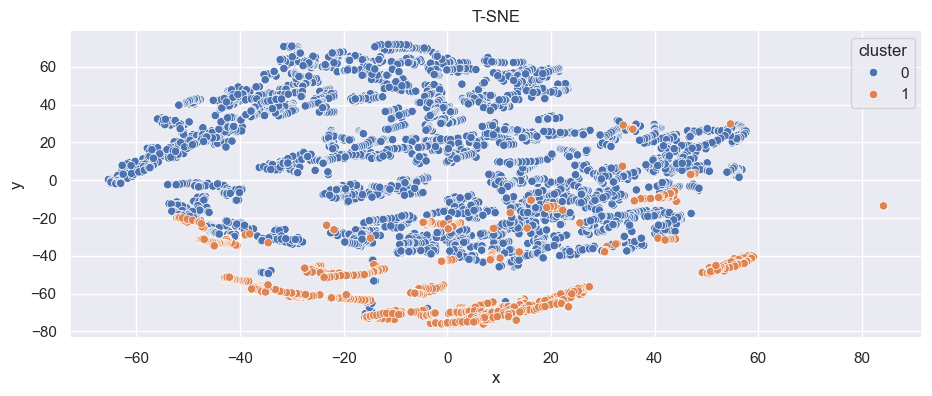

CPU times: total: 44.8 s
Wall time: 7.59 s


In [203]:
%%time
tsne2D = TSNE(n_components=2)
tsne_data2D = tsne2D.fit_transform(data[features])
tsne2D_df = pd.DataFrame(data =  tsne_data2D, columns = ['x', 'y'])

tsne2D_df['cluster'] = data['label']

sns.scatterplot(x='x', y='y', data=tsne2D_df, hue='cluster')
plt.title("T-SNE")
plt.show()

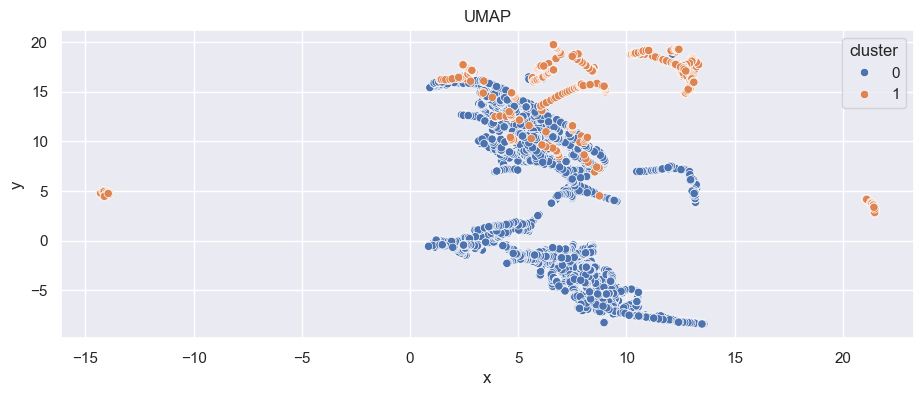

CPU times: total: 34.8 s
Wall time: 4.15 s


In [204]:
%%time
umap2D = UMAP(n_components=2)
umap_data2D = umap2D.fit_transform(data[features])
umap2D_df = pd.DataFrame(data =  umap_data2D, columns = ['x', 'y'])

umap2D_df['cluster'] = data['label']

sns.scatterplot(x='x', y='y', data=umap2D_df, hue='cluster')
plt.title("UMAP")
plt.show()

### Обучение моделей

In [314]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import time
import dill

Период возьмем в 30 минут. Данные после 2020-01-25 берем как эталонные и размечаем 1

In [2]:
features = ["temperature", "humidity", "CO2CosIRValue", "CO2MG811Value", "MOX1", "MOX2", "MOX3", "MOX4", "COValue"]

dt = "2020-01-25"

In [3]:
data = pd.read_csv('data\\database_gas.csv')
data.timestamp = data.timestamp.apply(lambda value: pd.to_datetime(value, utc=True)) 

data = data.groupby(pd.Grouper(key="timestamp", freq="30min")).agg("mean").reset_index()

data['label'] = np.where(data.timestamp>=dt, 1, 0)

In [4]:
data = data.dropna(axis=0)

In [5]:
y = data.label
X = data[features]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'train_test_split' is not defined

In [ ]:
X_test.shape

In [ ]:
X_test.to_csv('for_predict.csv')

In [310]:
num_folds = 5
random_state = 42
scoring = 'f1'

models = []

models.append(('LR', LogisticRegression()))
models.append(('StandardScaler + LR', Pipeline([('StandardScaler', StandardScaler()), ('LR', LogisticRegression())])))
models.append(('MinMaxScaler + LR', Pipeline([('MinMaxScaler', MinMaxScaler()), ('LR', LogisticRegression())])))

models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('StandardScaler + KNeighborsClassifier', Pipeline([('StandardScaler', StandardScaler()), ('KNeighborsClassifier', KNeighborsClassifier())])))
models.append(('MinMaxScaler + KNeighborsClassifier', Pipeline([('MinMaxScaler', MinMaxScaler()), ('KNeighborsClassifier', KNeighborsClassifier())])))

models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('StandardScaler + DecisionTreeClassifier', Pipeline([('StandardScaler', StandardScaler()), ('DecisionTreeClassifier', DecisionTreeClassifier())])))
models.append(('MinMaxScaler + DecisionTreeClassifier', Pipeline([('MinMaxScaler', MinMaxScaler()), ('DecisionTreeClassifier', DecisionTreeClassifier())])))

models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('StandardScaler + RandomForestClassifier', Pipeline([('StandardScaler', StandardScaler()), ('RandomForestClassifier', RandomForestClassifier())])))
models.append(('MinMaxScaler + RandomForestClassifier', Pipeline([('MinMaxScaler', MinMaxScaler()), ('RandomForestClassifier', RandomForestClassifier())])))

models.append(('CatBoostClassifier', CatBoostClassifier(verbose=0)))
models.append(('StandardScaler + CatBoostClassifier', Pipeline([('StandardScaler', StandardScaler()), ('CatBoostClassifier', CatBoostClassifier(verbose=0))])))
models.append(('MinMaxScaler + CatBoostClassifier', Pipeline([('MinMaxScaler', MinMaxScaler()), ('CatBoostClassifier', CatBoostClassifier(verbose=0))])))

In [311]:
results = []
names = []
times = []

for name, model in models:
    start = time.time()
    kfold = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)

    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)
    end = time.time()
    times.append(end - start)
    
    print(name, round(cv_results.mean(),2), round(cv_results.std(),2), round(end - start,2), ' sec.')

C:\Users\User\anaconda3\envs\myenv_py_3_10\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\envs\myenv_py_3_10\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

LR 0.95 0.01 0.1  sec.
StandardScaler + LR 0.95 0.01 0.05  sec.
MinMaxScaler + LR 0.93 0.02 0.05  sec.
KNeighborsClassifier 0.97 0.01 0.14  sec.
StandardScaler + KNeighborsClassifier 0.98 0.0 0.14  sec.
MinMaxScaler + KNeighborsClassifier 0.98 0.01 0.13  sec.
DecisionTreeClassifier 0.97 0.0 0.12  sec.
StandardScaler + DecisionTreeClassifier 0.97 0.01 0.13  sec.
MinMaxScaler + DecisionTreeClassifier 0.97 0.0 0.13  sec.
RandomForestClassifier 0.99 0.01 3.59  sec.
StandardScaler + RandomForestClassifier 0.99 0.01 3.69  sec.
MinMaxScaler + RandomForestClassifier 0.99 0.01 3.67  sec.
CatBoostClassifier 0.99 0.0 7.8  sec.
StandardScaler + CatBoostClassifier 0.99 0.0 7.72  sec.
MinMaxScaler + CatBoostClassifier 0.99 0.0 8.12  sec.


In [312]:
result_df = pd.DataFrame(
    {'names': names,
     'score': [round(np.mean(i),3) for i in results],
     'time': [round(i,3) for i in times]
    })

result_df

names  score   time
0                                        LR  0.954  0.098
1                       StandardScaler + LR  0.954  0.047
2                         MinMaxScaler + LR  0.925  0.054
3                      KNeighborsClassifier  0.969  0.141
4     StandardScaler + KNeighborsClassifier  0.985  0.145
5       MinMaxScaler + KNeighborsClassifier  0.977  0.131
6                    DecisionTreeClassifier  0.970  0.121
7   StandardScaler + DecisionTreeClassifier  0.974  0.127
8     MinMaxScaler + DecisionTreeClassifier  0.969  0.130
9                    RandomForestClassifier  0.986  3.592
10  StandardScaler + RandomForestClassifier  0.985  3.694
11    MinMaxScaler + RandomForestClassifier  0.988  3.668
12                       CatBoostClassifier  0.991  7.801
13      StandardScaler + CatBoostClassifier  0.991  7.723
14        MinMaxScaler + CatBoostClassifier  0.991  8.123

#### Модель 1

In [318]:
pipeline = Pipeline([('StandardScaler', StandardScaler()), ('KNeighborsClassifier', KNeighborsClassifier())])

pipeline.fit(X, y)

with open('models/knn_cl.dill', 'wb') as f:
    dill.dump(pipeline, f)

#### Модель 2

In [319]:
pipeline = Pipeline([('CatBoostClassifier', CatBoostClassifier(verbose=0))])

pipeline.fit(X, y)

with open('models/ctb_cl.dill', 'wb') as f:
    dill.dump(pipeline, f)

#### Модель 3

In [320]:
pipeline = Pipeline([('MinMaxScaler', MinMaxScaler()), ('RandomForestClassifier', RandomForestClassifier())])

pipeline.fit(X, y)

with open('models/rf_cl.dill', 'wb') as f:
    dill.dump(pipeline, f)